In [4]:
import matplotlib
print(matplotlib.matplotlib_fname()) #設定ファイルを表示（matplotlibrcは後で作ります）
print(matplotlib.rcParams['font.family']) #現在使用しているフォントを表示
print(matplotlib.get_configdir()) #設定ディレクトリを表示
print(matplotlib.get_cachedir()) #キャッシュディレクトリを表示

# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 前処理用ライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# モデル構築用ライブラリ（TensorFlow/Keras）
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
import keras.backend as K



# オプティマイザー
from keras.optimizers import Adam

plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc
['sans-serif']
/root/.config/matplotlib
/root/.cache/matplotlib


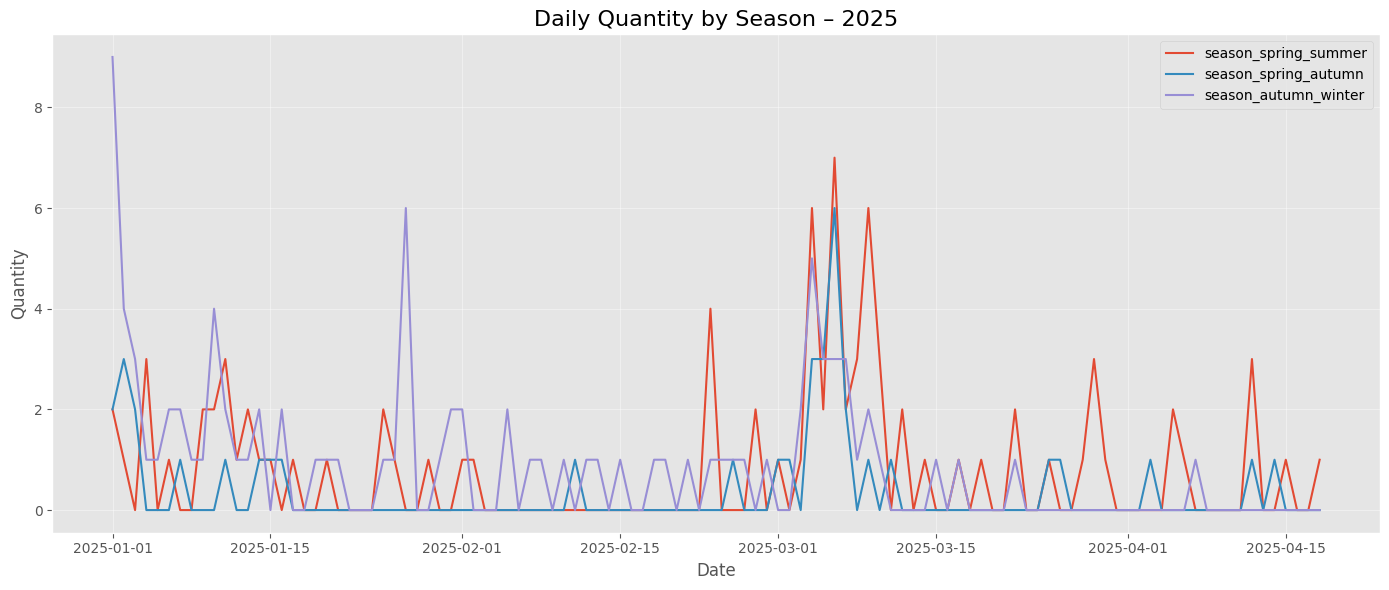

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. データ読み込み ----------
all_df = pd.read_csv(
    "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv",
    parse_dates=["order_time"]
)

# ---------- 2. 日次集計 ----------
season_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

daily_sum = (
    all_df[["order_time"] + season_cols]
      .groupby("order_time")[season_cols]
      .sum()
)

# ---------- 3. 2025 年度（暦年）にフィルタ ----------
daily_2025 = daily_sum.loc["2025"]          # 2025-01-01〜2025-12-31

# ---------- 4. 可視化 ----------
plt.figure(figsize=(14, 6))
for col in season_cols:
    plt.plot(daily_2025.index, daily_2025[col], label=col)

plt.title("Daily Quantity by Season – 2025", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Quantity", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


/tmp/ipykernel_26532/3278081581.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")  # 月ごとに集計


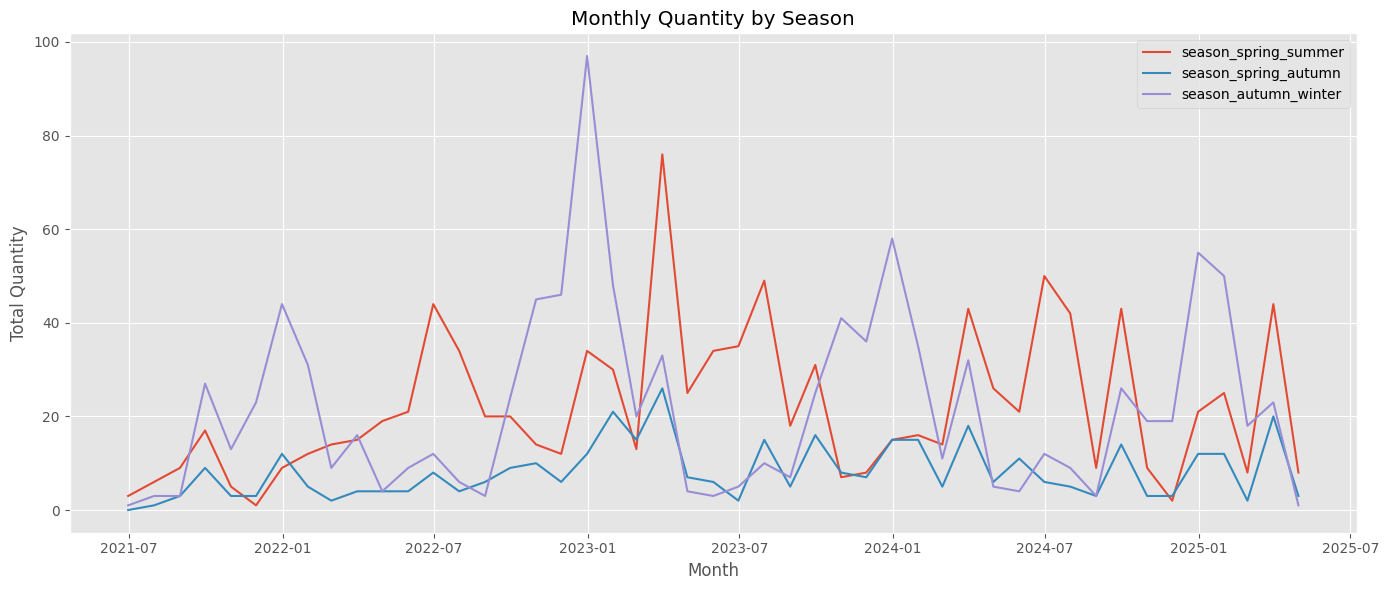

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
all_df = pd.read_csv('../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv')
all_df["order_time"] = pd.to_datetime(all_df["order_time"])

# 季節別の数量カラム
season_cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]

# 月別に集計
monthly_sum = (
    all_df[["order_time"] + season_cols]
    .set_index("order_time")
    .resample("M")  # 月ごとに集計
    .sum()
)

# グラフ描画
plt.figure(figsize=(14, 6))
for col in season_cols:
    plt.plot(monthly_sum.index, monthly_sum[col], label=col)

plt.title("Monthly Quantity by Season")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/500


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 - 1s - 45ms/step - loss: 0.3104 - val_loss: 0.0582
Epoch 2/500
32/32 - 1s - 17ms/step - loss: 0.2189 - val_loss: 0.0569
Epoch 3/500
32/32 - 1s - 16ms/step - loss: 0.1632 - val_loss: 0.0367
Epoch 4/500
32/32 - 1s - 24ms/step - loss: 0.1328 - val_loss: 0.0226
Epoch 5/500
32/32 - 1s - 18ms/step - loss: 0.1005 - val_loss: 0.0176
Epoch 6/500
32/32 - 1s - 17ms/step - loss: 0.0836 - val_loss: 0.0129
Epoch 7/500
32/32 - 1s - 16ms/step - loss: 0.0680 - val_loss: 0.0094
Epoch 8/500
32/32 - 1s - 16ms/step - loss: 0.0554 - val_loss: 0.0094
Epoch 9/500
32/32 - 1s - 17ms/step - loss: 0.0506 - val_loss: 0.0063
Epoch 10/500
32/32 - 1s - 19ms/step - loss: 0.0408 - val_loss: 0.0066
Epoch 11/500
32/32 - 1s - 18ms/step - loss: 0.0376 - val_loss: 0.0067
Epoch 12/500
32/32 - 1s - 17ms/step - loss: 0.0323 - val_loss: 0.0058
Epoch 13/500
32/32 - 1s - 16ms/step - loss: 0.0301 - val_loss: 0.0051
Epoch 14/500
32/32 - 1s - 16ms/step - loss: 0.0266 - val_loss: 0.0050
Epoch 15/500
32/32 - 1s - 16ms/step - los

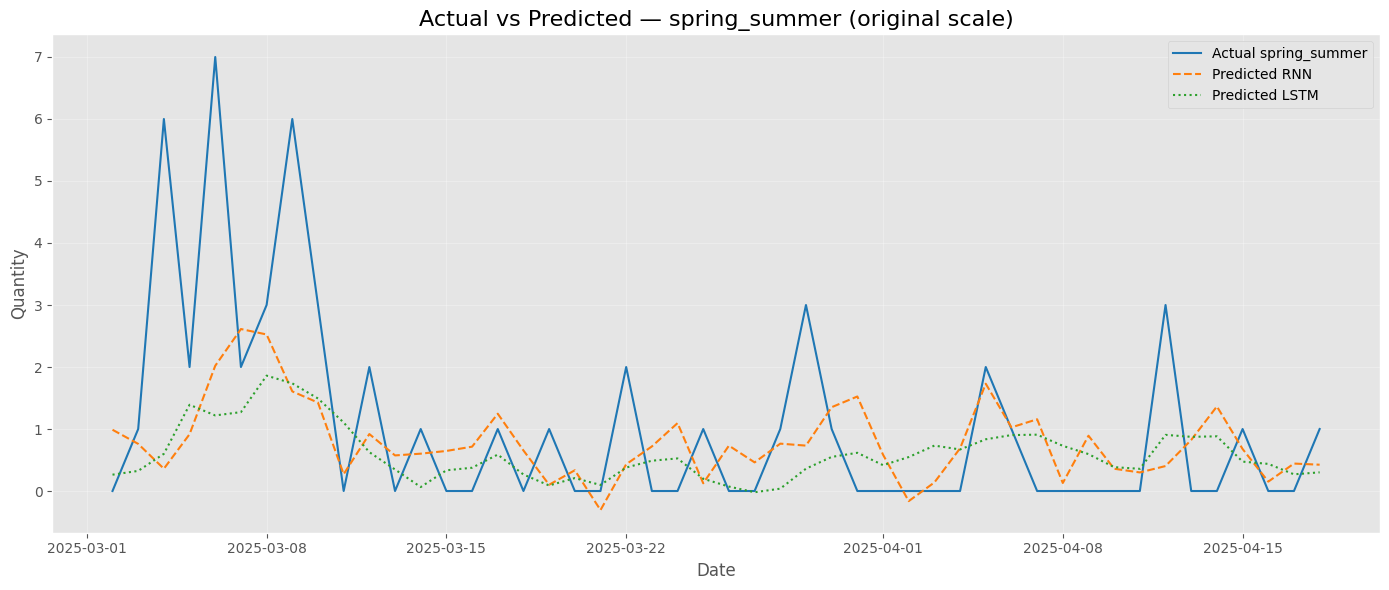

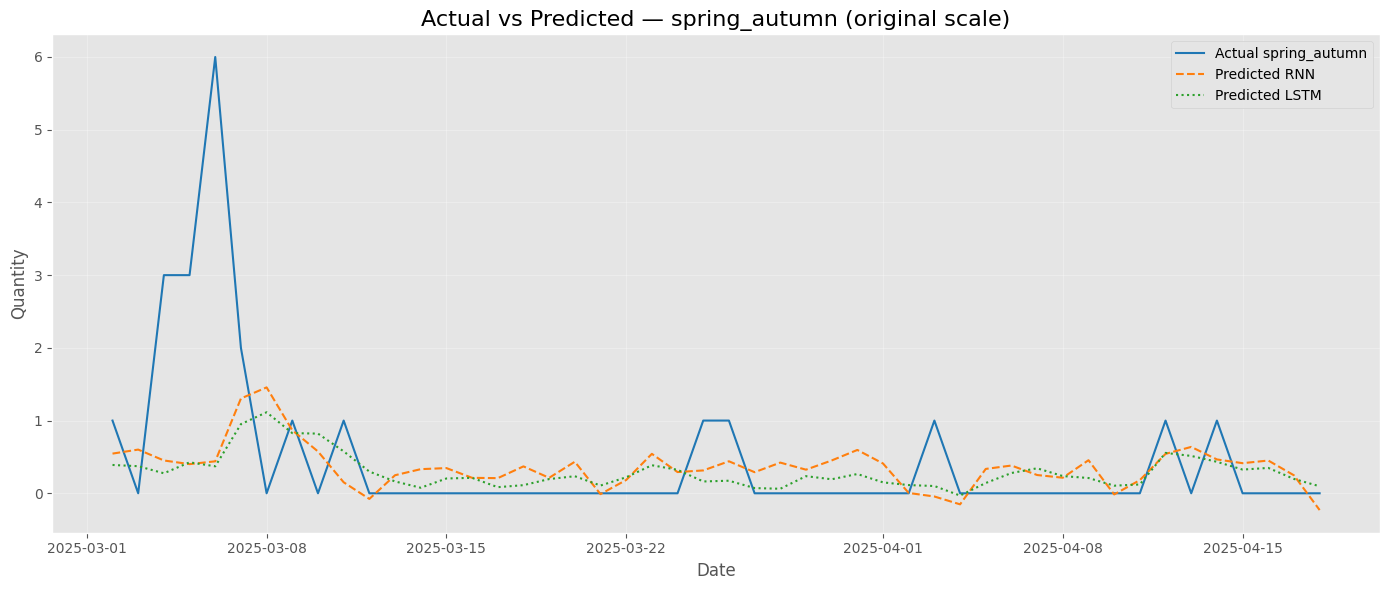

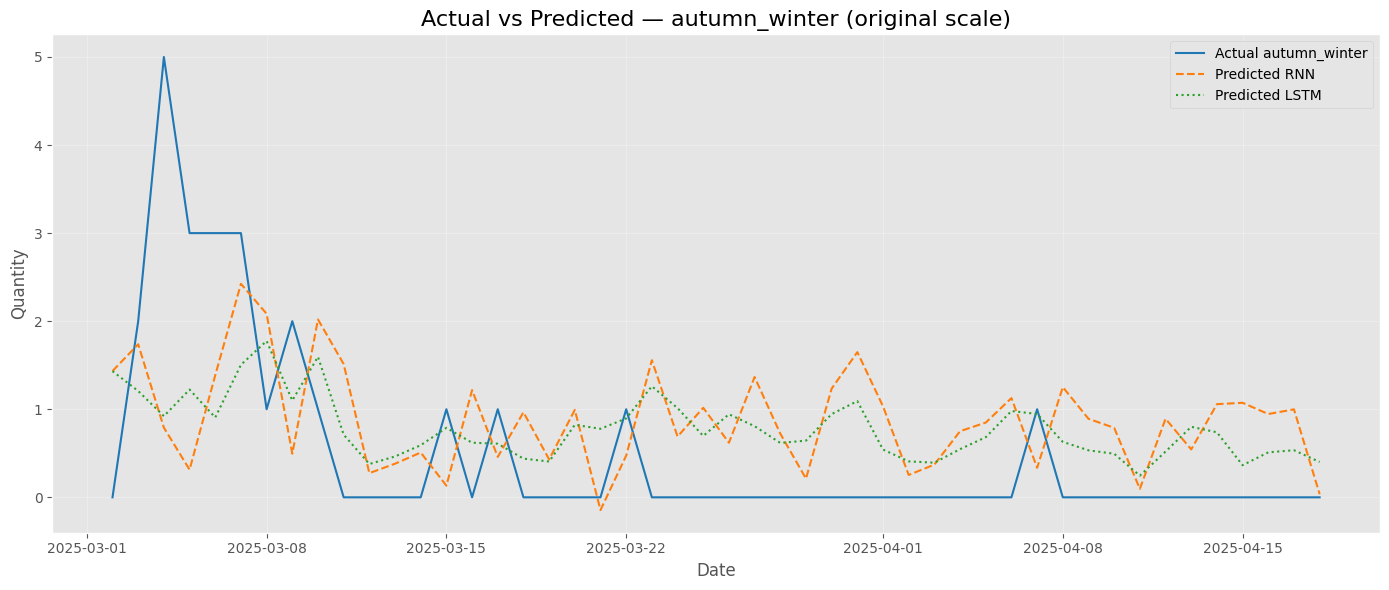

In [21]:
"""
daily_usedclothing_sales_forecast.py  (rev. – evaluate / plot on original scale)
-------------------------------------------------------------------------------
・日次中古衣料売上 2021-06-16〜2025-04-18
・目的変数  : season_spring_summer / spring_autumn / autumn_winter
・モデル    : SimpleRNN / LSTM
・評価      : 元スケール (inverse_transform 後)
・可視化    : 実測値 vs 予測値  ※日付インデックスで確認
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------------------------------------------------------
# 1. データ読み込み & 時系列 split
# ----------------------------------------------------------------------------
CSV_PATH = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"

all_df = pd.read_csv(
    CSV_PATH,
    parse_dates=["order_time"],
    index_col="order_time"
)

target_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

# ---- 時系列で train / val / test を切り分け ----
train_df = all_df.loc["2021-06-16":"2024-06-30"]

# ❶ 検証期間（val）を 7〜11 月に
val_df   = all_df.loc["2024-07-01":"2024-11-30"]

# ❷ テスト期間（test）を 2024-12-01〜2025-04-18 に拡張
test_df  = all_df.loc["2024-12-01":"2025-04-18"]


# ----------------------------------------------------------------------------
# 2. Min-Max 正規化 (入力 / 出力 別々)
# ----------------------------------------------------------------------------
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])

X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])

X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])      # 正規化版

# ----------------------------------------------------------------------------
# 3. teach-data 生成 (look_back = 91 日)
# ----------------------------------------------------------------------------
def make_xy(x_mat: np.ndarray, y_mat: np.ndarray, lb: int):
    xs, ys = [], []
    for i in range(len(x_mat) - lb):
        xs.append(x_mat[i:i+lb])
        ys.append(y_mat[i+lb])
    return np.asarray(xs, dtype="float32"), np.asarray(ys, dtype="float32")

LOOK_BACK = 91
trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)

seq_len, n_feat = trainX.shape[1], trainX.shape[2]

# ----------------------------------------------------------------------------
# 4. モデル
# ----------------------------------------------------------------------------
def build_rnn(seq_len, n_feat):
    m = Sequential([
        SimpleRNN(128, return_sequences=True,
                  input_shape=(seq_len, n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

early_stop = EarlyStopping(monitor="val_loss",
                           patience=10,
                           restore_best_weights=True,
                           verbose=1)

# ---- RNN ----
K.clear_session()
rnn = build_rnn(seq_len, n_feat)
rnn.fit(trainX, trainY,
        epochs=500, batch_size=32, shuffle=False,
        validation_data=(valX, valY),
        callbacks=[early_stop], verbose=2)

# ---- LSTM ----
K.clear_session()
lstm = build_lstm(seq_len, n_feat)
lstm.fit(trainX, trainY,
         epochs=500, batch_size=32, shuffle=False,
         validation_data=(valX, valY),
         callbacks=[early_stop], verbose=2)

# ----------------------------------------------------------------------------
# 5. 予測 → 元スケールへ inverse_transform
# ----------------------------------------------------------------------------
pred_rnn  = rnn.predict(testX,  verbose=0)
pred_lstm = lstm.predict(testX, verbose=0)

y_true_scaled = testY                            # 正規化スケール
pred_rnn_orig  = y_scaler.inverse_transform(pred_rnn)
pred_lstm_orig = y_scaler.inverse_transform(pred_lstm)
y_true_orig    = y_scaler.inverse_transform(y_true_scaled)

# ----------------------------------------------------------------------------
# 6. 評価 (元スケール)
# ----------------------------------------------------------------------------
def reg_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, p)
    return mse, rmse, mae

print("\n=== Evaluation (ORIGINAL SCALE) ===")
for i, col in enumerate(target_cols):
    mse_r, rmse_r, mae_r = reg_metrics(y_true_orig[:, i], pred_rnn_orig[:, i])
    mse_l, rmse_l, mae_l = reg_metrics(y_true_orig[:, i], pred_lstm_orig[:, i])
    print(f"{col:<22} | RNN  MSE={mse_r:10.2f}  RMSE={rmse_r:7.2f}  MAE={mae_r:7.2f}"
          f"   ||   LSTM MSE={mse_l:10.2f}  RMSE={rmse_l:7.2f}  MAE={mae_l:7.2f}")

# ----------------------------------------------------------------------------
# 7. 可視化 ── 日付軸で実測 vs 予測
# ----------------------------------------------------------------------------
disp_names = ["spring_summer", "spring_autumn", "autumn_winter"]

# test_df から教師データ作成時に LOOK_BACK 日削った分を合わせる
test_dates = test_df.index[LOOK_BACK:]

for i, name in enumerate(disp_names):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true_orig[:, i],
             label=f"Actual {name}", c="#1f77b4")
    plt.plot(test_dates, pred_rnn_orig[:, i],
             label="Predicted RNN", c="#ff7f0e", ls="--")
    plt.plot(test_dates, pred_lstm_orig[:, i],
             label="Predicted LSTM", c="#2ca02c", ls=":")
    
    plt.title(f"Actual vs Predicted — {name} (original scale)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Quantity", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Epoch 1/500


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 - 2s - 51ms/step - loss: 0.3614 - val_loss: 0.0915
Epoch 2/500
32/32 - 1s - 17ms/step - loss: 0.2487 - val_loss: 0.0745
Epoch 3/500
32/32 - 1s - 16ms/step - loss: 0.2055 - val_loss: 0.0459
Epoch 4/500
32/32 - 1s - 18ms/step - loss: 0.1591 - val_loss: 0.0241
Epoch 5/500
32/32 - 1s - 16ms/step - loss: 0.1270 - val_loss: 0.0244
Epoch 6/500
32/32 - 1s - 16ms/step - loss: 0.1020 - val_loss: 0.0179
Epoch 7/500
32/32 - 1s - 16ms/step - loss: 0.0857 - val_loss: 0.0136
Epoch 8/500
32/32 - 1s - 19ms/step - loss: 0.0750 - val_loss: 0.0113
Epoch 9/500
32/32 - 1s - 20ms/step - loss: 0.0621 - val_loss: 0.0098
Epoch 10/500
32/32 - 1s - 17ms/step - loss: 0.0558 - val_loss: 0.0102
Epoch 11/500
32/32 - 1s - 17ms/step - loss: 0.0465 - val_loss: 0.0076
Epoch 12/500
32/32 - 1s - 16ms/step - loss: 0.0434 - val_loss: 0.0080
Epoch 13/500
32/32 - 1s - 17ms/step - loss: 0.0412 - val_loss: 0.0077
Epoch 14/500
32/32 - 1s - 17ms/step - loss: 0.0352 - val_loss: 0.0050
Epoch 15/500
32/32 - 1s - 16ms/step - los

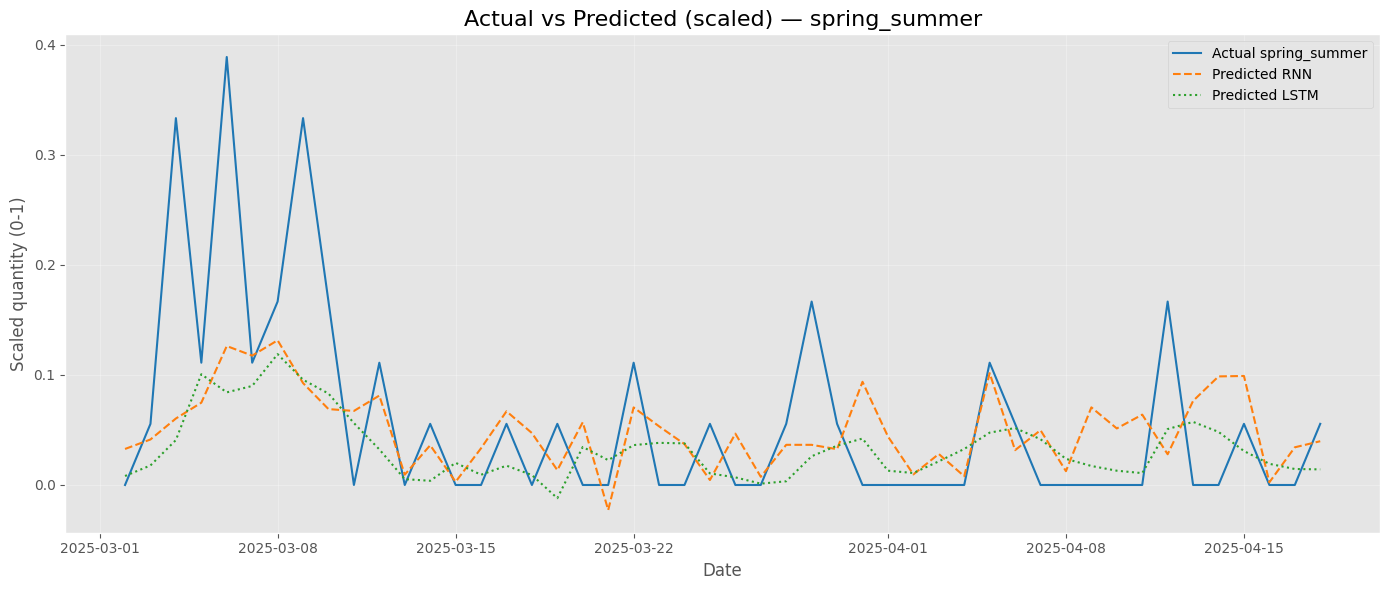

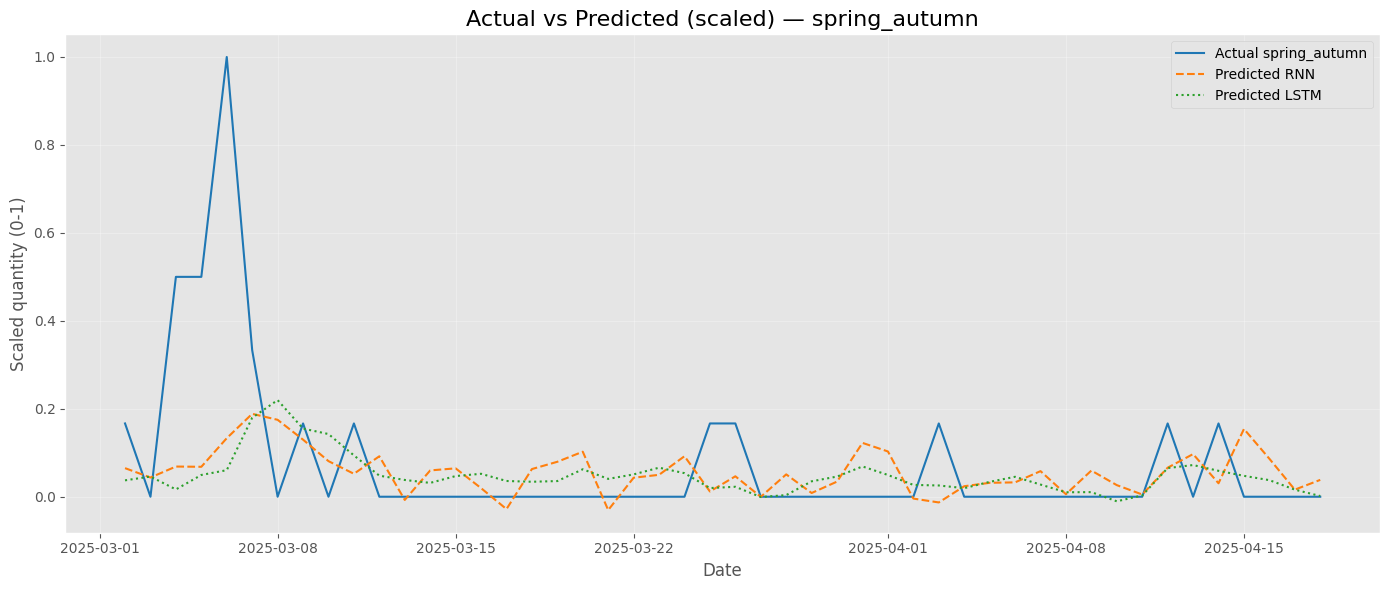

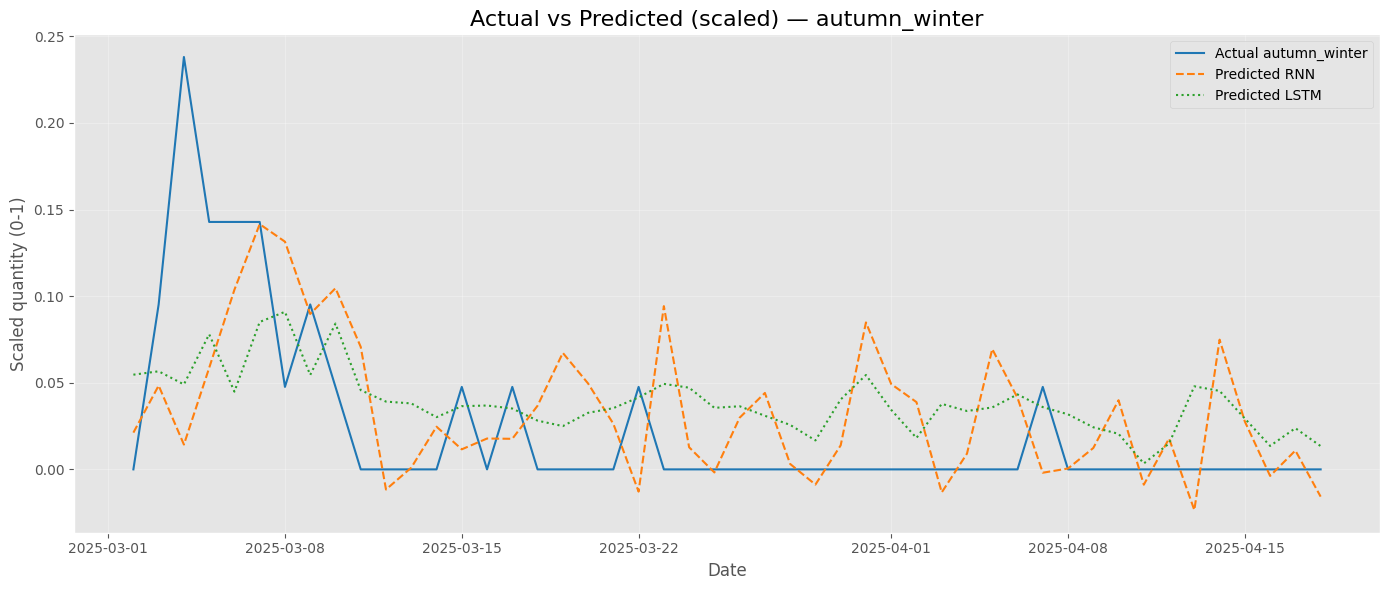

In [22]:
"""
daily_usedclothing_sales_forecast.py  (rev. – evaluate / plot on **scaled** data)
-------------------------------------------------------------------------------
・日次中古衣料売上 2021-06-16〜2025-04-18
・目的変数  : season_spring_summer / spring_autumn / autumn_winter
・モデル    : SimpleRNN / LSTM
・評価      : 0-1 に正規化したスケールで実施
・可視化    : 実測値 vs 予測値（scaled）
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------------------------------------------------------------
# 1. データ読み込み & split
# ----------------------------------------------------------------------------
CSV_PATH = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"

all_df = (
    pd.read_csv(CSV_PATH, parse_dates=["order_time"])
      .set_index("order_time")
)

target_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

train_df = all_df.loc["2021-06-16":"2024-06-30"]
val_df   = all_df.loc["2024-07-01":"2024-11-30"]
test_df  = all_df.loc["2024-12-01":"2025-04-18"]


# ----------------------------------------------------------------------------
# 2. Min-Max スケーリング（X と Y 別々）
# ----------------------------------------------------------------------------
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])

X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])

X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])       # ここが “scaled” 実測値


# ----------------------------------------------------------------------------
# 3. teach-data 生成
# ----------------------------------------------------------------------------
def make_xy(xmat: np.ndarray, ymat: np.ndarray, lb: int = 91):
    xs, ys = [], []
    for i in range(len(xmat) - lb):
        xs.append(xmat[i:i+lb])
        ys.append(ymat[i+lb])
    return np.asarray(xs, dtype="float32"), np.asarray(ys, dtype="float32")

LOOK_BACK = 91
trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)

seq_len, n_feat = trainX.shape[1], trainX.shape[2]


# ----------------------------------------------------------------------------
# 4. モデル
# ----------------------------------------------------------------------------
def build_rnn(seq_len, n_feat):
    m = Sequential([
        SimpleRNN(128, return_sequences=True,
                  input_shape=(seq_len, n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


early_stop = EarlyStopping(monitor="val_loss",
                           patience=10,
                           restore_best_weights=True,
                           verbose=1)

# ---- RNN ----
K.clear_session()
rnn = build_rnn(seq_len, n_feat)
rnn.fit(trainX, trainY,
        epochs=500,
        batch_size=32,
        shuffle=False,
        validation_data=(valX, valY),
        callbacks=[early_stop],
        verbose=2)

# ---- LSTM ----
K.clear_session()
lstm = build_lstm(seq_len, n_feat)
lstm.fit(trainX, trainY,
         epochs=500,
         batch_size=32,
         shuffle=False,
         validation_data=(valX, valY),
         callbacks=[early_stop],
         verbose=2)


# ----------------------------------------------------------------------------
# 5. 予測（**scaled**） & 評価
# ----------------------------------------------------------------------------
pred_rnn  = rnn.predict(testX,  verbose=0)   # 0-1 スケール
pred_lstm = lstm.predict(testX, verbose=0)   # 0-1 スケール
y_true    = testY                            # 0-1 スケール

def reg_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, p)
    return mse, rmse, mae

print("\n=== Evaluation (scaled 0-1) ===")
for i, col in enumerate(target_cols):
    mse_r, rmse_r, mae_r = reg_metrics(y_true[:, i], pred_rnn[:, i])
    mse_l, rmse_l, mae_l = reg_metrics(y_true[:, i], pred_lstm[:, i])
    print(f"{col:<22} | RNN  MSE={mse_r:8.5f}  RMSE={rmse_r:7.5f}  MAE={mae_r:7.5f}"
          f"   ||   LSTM MSE={mse_l:8.5f}  RMSE={rmse_l:7.5f}  MAE={mae_l:7.5f}")


# ----------------------------------------------------------------------------
# 6. 可視化（scaled 0-1）
# ----------------------------------------------------------------------------
disp_names = ["spring_summer", "spring_autumn", "autumn_winter"]

test_dates = test_df.index[LOOK_BACK:]      # 91 日分シフト

for i, name in enumerate(disp_names):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true[:, i],
             label=f"Actual {name}", c="#1f77b4")
    plt.plot(test_dates, pred_rnn[:, i],
             label="Predicted RNN", c="#ff7f0e", ls="--")
    plt.plot(test_dates, pred_lstm[:, i],
             label="Predicted LSTM", c="#2ca02c", ls=":")
    plt.title(f"Actual vs Predicted (scaled) — {name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Scaled quantity (0-1)", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
